#  Les Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Librairie re pour traiter des caratères spécifiques
import re
#Librairie de netoyage de tweets
!pip install tweet-preprocessor
import preprocessor as tpr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

# Creation du DataFrame

In [2]:
# Importation du premier dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset.json'))

In [3]:
sarc = pd.DataFrame(data)

In [4]:
# Importation du deuxieme dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))

In [5]:
sarc_2 = pd.DataFrame(data)

# Comparaison et fusion des 2 datasets

In [6]:
sarc_2['is_sarcastic'].mean()

0.476396799329117

In [7]:
sarc['is_sarcastic'].mean()

0.43895316185555433

In [8]:
# Fusion des 2 datasets et suppression des doublons
sarc = pd.concat([sarc,sarc_2])
sarc = sarc.drop_duplicates()
sarc.reset_index(drop=True,inplace=True)

In [9]:
sarc.describe(include='all')

,article_link,headline,is_sarcastic
count,28617,28617,28617.000000
unique,28617,28503,NaN
top,https://www.huffingtonpost.com/entry/sonomas-w...,"'no way to prevent this,' says only nation whe...",NaN
freq,1,12,NaN
mean,NaN,NaN,0.476395
std,NaN,NaN,0.499451
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


In [10]:
# Check des cases vides
sarc.isnull().any()

article_link    False
headline        False
is_sarcastic    False
dtype: bool

# Data Cleaning

In [11]:
# Utilisation de la librairie re pour traiter des caratères spécifiques
# Choix des caractères à effacer et à remplacer

replace_q = re.compile("(\?)")
replace_ex = re.compile("(\!)")
to_remove = re.compile("(\.)|(\;)|(\:)|(\')|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")

In [12]:
# Fonction de cleaning de la data utilisant tweet-processor et re

def cleaner(line):
    tmp_line = tpr.clean(line)
    tmp_line = replace_q.sub(" ? ",tmp_line.lower())
    tmp_line = replace_ex.sub(" ! ",tmp_line)
    tmp_line = to_remove.sub("",tmp_line)
    return tmp_line

In [13]:
# Cleaning de la data
h_clean = sarc['headline'].apply(cleaner)

# Ajout de la data clean au dataset
sarc["headline_clean"] = h_clean

In [14]:
sarc

,article_link,headline,is_sarcastic,headline_clean
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...
...,...,...,...,...
28612,https://www.theonion.com/tyson-holds-contest-t...,tyson holds contest to let fans submit new ide...,1,tyson holds contest to let fans submit new ide...
28613,https://politics.theonion.com/increasingly-coc...,increasingly cocky bernie sanders announces he...,1,increasingly cocky bernie sanders announces he...
28614,https://www.theonion.com/cash-strapped-zuckerb...,cash-strapped zuckerberg forced to sell 11 mil...,1,cash-strapped zuckerberg forced to sell millio...
28615,https://local.theonion.com/grocery-store-bar-a...,grocery store bar actually has great little ha...,1,grocery store bar actually has great little ha...


In [15]:
sarc['headline'][28589]

'stock value of billions of otherwise worthless data, photos, videos, opinions plummets'

In [16]:
sarc['headline_clean'][28589]

'stock value of billions of otherwise worthless data photos videos opinions plummets'

# Construction des sets Train et Test

In [17]:
# Construction des features et de la target
x = sarc.headline_clean.values
y = sarc.is_sarcastic.values

x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size=0.3,
                                                   stratify=y)

# Vectorisation

In [18]:
#Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(binary=True, stop_words="english")


x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [19]:
#Vectorisation avec TfidfVectorizer
t_vectorizer = TfidfVectorizer(use_idf=True, stop_words="english")

t_vectorized = t_vectorizer.fit(x)

x_train_tfidf = t_vectorizer.transform(x_train)
x_test_tfidf = t_vectorizer.transform(x_test)

# Construction des modèles

**Regression Logistique**

In [20]:
# Regression Logistique avec CountVectorizer

cv_reg = LogisticRegression()
cv_reg.fit(x_train_vec,y_train)

LogisticRegression()

In [21]:
y_train_vec_pred = cv_reg.predict(x_train_vec)

In [22]:
y_test_vec_pred = cv_reg.predict(x_test_vec)

In [23]:
# score train
cv_reg.score(x_train_vec,y_train)


0.9497279217213319

In [24]:
# score train
cv_reg.score(x_test_vec,y_test)

0.8030514791521081

In [25]:
# Regression Logistique avec TfidfVectorizer

tv_reg = LogisticRegression()
tv_reg.fit(x_train_tfidf,y_train)

LogisticRegression()

In [26]:
# score train
tv_reg.score(x_train_tfidf,y_train)

0.901652438719984

In [27]:
# score test
tv_reg.score(x_test_tfidf,y_test)

0.795364546936874

    Matrices de confusion

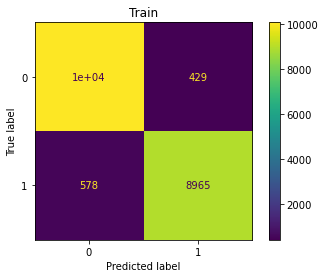

accuracy-score on train set :  0.9497279217213319


In [28]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_reg.score(x_train_vec, y_train))

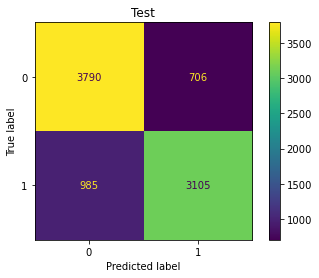

accuracy-score on test set :  0.8030514791521081


In [29]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_reg.score(x_test_vec, y_test))

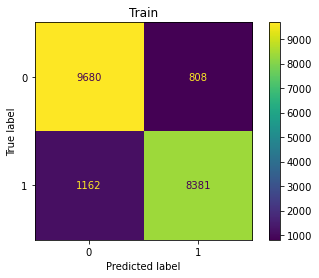

accuracy-score on train set :  0.901652438719984


In [30]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_train_tfidf,y_train)
cm_tfidf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_reg.score(x_train_tfidf, y_train))

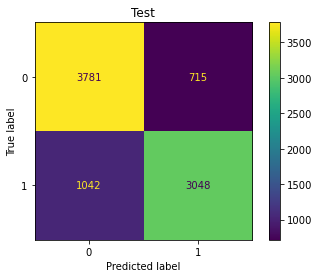

accuracy-score on test set :  0.795364546936874


In [31]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_test_tfidf,y_test)
cm_tfidf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_reg.score(x_test_tfidf, y_test))

**Random Forest**

In [32]:
# Randomforest avec CountVectorizer

cv_rf = RandomForestClassifier()
cv_rf.fit(x_train_vec,y_train)

RandomForestClassifier()

In [33]:
# score train
cv_rf.score(x_train_vec,y_train)

0.9999500773800609

In [34]:
# score test
cv_rf.score(x_test_vec,y_test)

0.7537852317726531

In [35]:
# Randomforest avec TfidfVectorizer

tv_rf = RandomForestClassifier()
tv_rf.fit(x_train_tfidf,y_train)

RandomForestClassifier()

In [36]:
# score train
tv_rf.score(x_train_tfidf,y_train)

1.0

In [37]:
# score test
tv_rf.score(x_test_tfidf,y_test)

0.7568134171907757

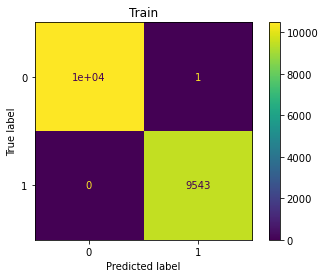

accuracy-score on train set :  0.9999500773800609


In [38]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_rf.score(x_train_vec, y_train))

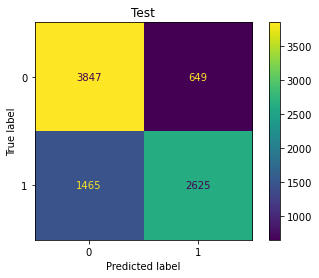

accuracy-score on test set :  0.7537852317726531


In [39]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_rf.score(x_test_vec, y_test))

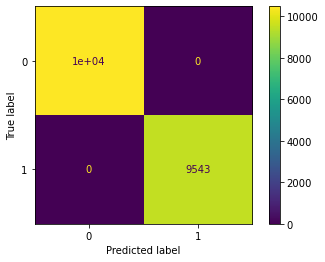

accuracy-score on train set :  1.0


In [40]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_train_tfidf,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_rf.score(x_train_tfidf, y_train))

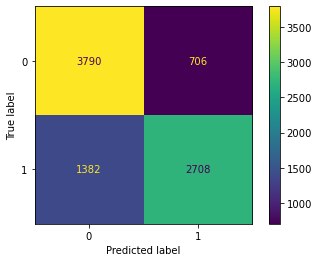

accuracy-score on test set :  0.7568134171907757


In [41]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_test_tfidf,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_rf.score(x_test_tfidf, y_test))

**Support Vector Machine**

In [42]:
# SVM avec CountVectorizer

cv_svm = SVC()
cv_svm.fit(x_train_vec,y_train)

SVC()

In [43]:
# score train
cv_svm.score(x_train_vec,y_train)

0.970895112575508

In [44]:
# score test
cv_svm.score(x_test_vec,y_test)

0.7952480782669462

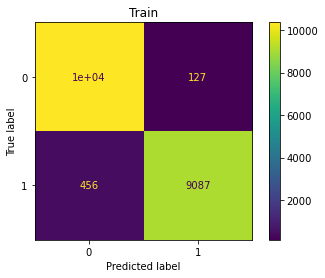

accuracy-score on train set :  0.970895112575508


In [45]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_svm.score(x_train_vec, y_train))

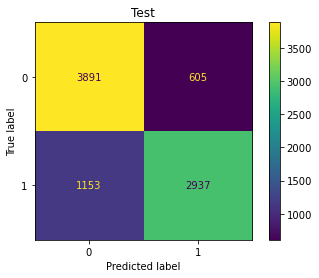

accuracy-score on test set :  0.7952480782669462


In [46]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_svm.score(x_test_vec, y_test))

In [47]:
# SVM avec TfidfVectorizer

tv_svm = SVC()
tv_svm.fit(x_train_tfidf,y_train)

SVC()

In [48]:
# score train
tv_svm.score(x_train_tfidf,y_train)

0.989416404572912

In [49]:
# score test
tv_svm.score(x_test_tfidf,y_test)

0.8013044491031912

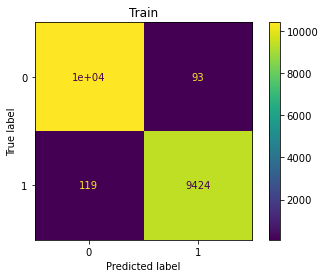

accuracy-score on train set :  0.989416404572912


In [50]:
#Matrice et score pour train avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_train_tfidf,y_train)
cm_tf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_svm.score(x_train_tfidf, y_train))

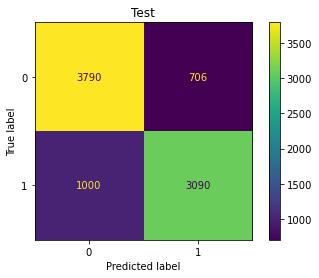

accuracy-score on test set :  0.8013044491031912


In [51]:
#Matrice et score pour test avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_test_tfidf,y_test)
cm_tf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_svm.score(x_test_tfidf, y_test))